# **前日の20:00までのデータを用いて翌日の00:00~23:30までの日射時間(sl)をMLPで予測する**

### **必要な関数・ライブラリ**

In [65]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random

%matplotlib inline

import time

In [66]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [67]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [297]:
def set_datetime(x):
    '''
    指定されたdatetime形式になるように整形
    '''
    str_month = str(x.month)
    if x.month - 10 < 0:
        str_month = "0"+str(x.month)
    str_day = str(x.day)
    if x.day - 10 < 0:
        str_day = "0"+str(x.day)
    str_hour = str(x.hour)
    if x.hour - 10 < 0:
        str_hour = "0"+str(x.hour)
    str_minute = str(x.minute)
    if x.minute == 0:
        str_minute = "00"
    if x.minute == 0 and x.hour == 0:
        str_minute = "00"
        str_hour = "24"
        str_day = str(x.day - 1)
        if (x.day - 1) - 10 < 0:
            str_day = "0"+str(x.day - 1)
                              
    return str(x.year)+str_month+str_day+str_hour+str_minute

In [68]:
def get_30(tmp_data):
    
    tmp_data = tmp_data[["datetime", "pr", "max_ws", "ave_ws", "max_tp", "min_tp", "sl"]]
    
    # 欠損値を一つ前の値で置換/output_data
    tmp_data = tmp_data.fillna(method='bfill')
    tmp_30 = tmp_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    # datetimeのカラムを復活させる
    tmp_30['datetime'] = tmp_30.index
    tmp_30.index = np.arange(len(tmp_30))
    tmp_30.head()
    return tmp_30

In [69]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [70]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [71]:
def get_input_data(X):
    '''
    全時系列データから00:00 ~ 20:00までのデータごとに分割する
    '''
    input_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(X) // 48
    reshaped_size = X[0:41].shape[0] * X[0:41].shape[1]
    for i in range(total_size+1):
        each_data = X[(i*48):(i*48+41)]
        reshaped = each_data.reshape(reshaped_size)
        input_list.append(list(reshaped))
    input_list = np.array(input_list)
    return input_list

In [72]:
def get_output_data(Y):
    '''
    全時系列データから00:00 ~ 23:30までのデータごとに分割する
    '''
    output_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(Y) // 48
    for i in range(total_size):
        each_data = Y[(i*48):(i*48+48)]
        reshaped = each_data.reshape(48)
        output_list.append(list(reshaped))
    output_list = np.array(output_list)
    return output_list

In [100]:
def drop_nan(X, Y):
    '''
    Yにnanが含まれるものと削除(他のとこにあるdrop_nanとは別物なので注意)
    '''
    mask = []
    for i in range(len(Y)):
        if np.isnan(Y[i]).sum() == 0:
            mask.append(True)
        else:
            mask.append(False)
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [74]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

### **データの準備**

In [206]:
target_place = 2

In [178]:
# 発電量データ
output_data = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')
output_data = set_time(output_data, 'datetime')
output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))

In [207]:
output_30 = output_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
output_30['datetime'] = output_30.index
output_30 = output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30.index = np.arange(len(output_30))

In [208]:
# 発電所近くのamedas
# アメダスデータの読み込み
if target_place == 1 or target_place == 2:
    # 対象アメダスは横浜アメダス, amd_46106
    # 各amdidはamd_masterに記載されている
    target_amd_data = pd.read_csv('data/raw_data/amd_46106.tsv', delimiter = '\t')
    target_amd_data = set_time(target_amd_data, 'datetime')
    target_amd_data['datetime'] = target_amd_data['datetime'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    # 甲府アメダスのデータを使って予測する, amd_49142
    # 各amdidはamd_masterに記載されている
    target_amd_data = pd.read_csv('data/raw_data/amd_49142.tsv', delimiter = '\t')
    target_amd_data = set_time(target_amd_data, 'datetime')
    target_amd_data['datetime'] = target_amd_data['datetime'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place")

In [209]:
# 欠損値を一つ前の値で置換/output_data
target_amd_data = target_amd_data.fillna(method='bfill')
target_30 = target_amd_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

# datetimeのカラムを復活させる
target_30['datetime'] = target_30.index
target_30 = target_30[['datetime', 'sl']]
target_30.index = np.arange(len(target_30))
target_30.head()

,datetime,sl
0,2012-01-01 00:00:00,0.0
1,2012-01-01 00:30:00,0.0
2,2012-01-01 01:00:00,0.0
3,2012-01-01 01:30:00,0.0
4,2012-01-01 02:00:00,0.0


In [210]:
# 名古屋アメダスのデータを使って予測する, amd_51106
# 各amdidはamd_masterに記載されている
amd_data = pd.read_csv('data/raw_data/amd_51106.tsv', delimiter = '\t')
amd_data = set_time(amd_data, 'datetime')
amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))    
amd_30 = get_30(amd_data)

In [211]:
# 浜松のデータamd_50456を加える
tmp_data = pd.read_csv('data/raw_data/amd_50456.tsv', delimiter = '\t')
tmp_data = set_time(tmp_data, 'datetime')
tmp_data['datetime'] = tmp_data['datetime'].map(lambda x : pd.to_datetime(x))
tmp_30 = get_30(tmp_data)
suffix = 1
result = pd.merge(amd_30, tmp_30, on='datetime', suffixes = ('_'+str(suffix), '_'+str(suffix+1)))
suffix += 2

In [212]:
# 当該箇所のアメダスのデータを加える
result = pd.merge(result, get_30(target_amd_data), on='datetime', suffixes = ('_'+str(suffix), '_'+str(suffix+1)))
suffix += 2

In [213]:
# 大阪のデータamd_62078を加える
tmp_data = pd.read_csv('data/raw_data/amd_50456.tsv', delimiter = '\t')
tmp_data = set_time(tmp_data, 'datetime')
tmp_data['datetime'] = tmp_data['datetime'].map(lambda x : pd.to_datetime(x))
tmp_30 = get_30(tmp_data)
result = pd.merge(result, tmp_30, on='datetime', suffixes = ('_'+str(suffix), '_'+str(suffix+1)))
suffix += 2

In [214]:
# 飯田のデータamd_62078を加える
tmp_data = pd.read_csv('data/raw_data/amd_48767.tsv', delimiter = '\t')
tmp_data = set_time(tmp_data, 'datetime')
tmp_data['datetime'] = tmp_data['datetime'].map(lambda x : pd.to_datetime(x))
tmp_30 = get_30(tmp_data)
result = pd.merge(result, tmp_30, on='datetime', suffixes = ('_'+str(suffix), '_'+str(suffix+1)))
suffix += 2

In [215]:
# モデル構築のためにデータを分割する

# 学習に必要なデータ
# 前日の00:00 ~ 20:00のデータで翌日の0:00 ~ 23:30を予測する
train_x_s_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_x_e_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2015-12-30 20:00')].index[0]
train_y_s_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2012-01-02 00:00')].index[0]
train_y_e_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

output_sl = target_30["sl"][train_y_s_idx:train_y_e_idx+1]
output_kwh = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
input_data = result.drop(["datetime"], axis=1)[train_x_s_idx:train_x_e_idx+1]

# 予測に必要なデータ
# 前日の00:00 ~ 20:00のデータで翌日の0:00 ~ 23:30を予測する
test_y_s_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2016-1-1 00:00')].index[0]
test_y_e_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2017-3-31 23:30')].index[0]
test_x_s_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2015-12-31 00:00')].index[0]
test_x_e_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2017-3-30 20:00')].index[0]

test_input_data = result.drop(["datetime"], axis=1)[test_x_s_idx:test_x_e_idx+1]
test_output_sl = target_30[["sl"]][test_y_s_idx:test_y_e_idx+1]

In [216]:
# MLPに突っ込むための準備をする

# min-max正規化しておく
normalized_input = (input_data - input_data.min()) / (input_data.max() - input_data.min())
normalized_input = np.array(normalized_input)
normalized_output = (output_sl - output_sl.min()) / (output_sl.max() - output_sl.min())
normalized_output = np.array(normalized_output)
normalized_kwh = (output_kwh - output_kwh.min()) /( output_kwh.max() - output_kwh.min())
normalized_kwh = np.array(normalized_kwh)

input_list = get_input_data(normalized_input)
output_list = get_output_data(normalized_output)
kwh_list = get_output_data(normalized_kwh)

input_list, kwh_list = drop_nan(input_list, kwh_list)

# testデータの入力を用意
normalized_test_input = (test_input_data - test_input_data.min()) / (test_input_data.max() - test_input_data.min())
normalized_test_input = np.array(normalized_test_input)

test_input_list = get_input_data(normalized_test_input)

# denormalize用
output_max = float(output_sl.max())
output_min = float(output_sl.min())
kwh_max = float(output_kwh.max())
kwh_min = float(output_kwh.min())

# MLPに突っ込むためにデータを整形
X = np.array(input_list).reshape(input_list.shape[0], input_list.shape[1])
Y = np.array(normalized_output).reshape(output_list.shape[0], output_list.shape[1])
KWH = np.array(kwh_list).reshape(kwh_list.shape[0], kwh_list.shape[1])
X_predict = np.array(test_input_list).reshape(test_input_list.shape[0], test_input_list.shape[1])

### **モデルの構築**

条件:翌日の気温を予測するには前日の20:00までの気象情報しか使えない

モデル:翌日の30分毎の気温を前日の20:00までの各所のアメダスの気象情報で予測させる

入力:各所のアメダス情報をひとまとめにした配列

出力:0:00, 0:30, .... , 23:00, 23:30の気温の配列

とりあえず一つの箇所のデータを使って予測


In [217]:
class MLP:
    def __init__(self, X, Y, epochs = 100, hidden_size = 100, batch_size = 100, model_name = "test_model"):
        # 学習データと検証用データに分けておく
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.1)))
        self.X = X # 入力
        self.Y = Y # 教師
        self.X_val = X_val # 検証用
        self.Y_val = Y_val #検証用
        
        '''
        諸変数の設定
        '''
        self.input_layer_size = self.X.shape[1] #入力層の数
        self.hidden_layer_size = hidden_size # 隠れ層の数、適当
        self.output_layer_size = self.Y.shape[1] #出力層の数
        self.batch_size = batch_size #バッチサイズ
        self.learning_rate = 0.01 # 学習率 適当
        self.epochs = epochs #エポック数
        
        # 学習データの保存
        self.model_name = str(model_name)
        
        
    def shuffle(self):
        '''
        ミニバッチかする際にランダムにシャッフル
        '''
        idx = [i for i in range(self.X.shape[0])]
        np.random.shuffle(idx)
        xs = np.array([[y for y in list(self.X[r])] for r in idx])
        ys = np.array([self.Y[r] for r in idx])
        return xs, ys
        
    def inference(self, input_ph):
        '''
        グラフの構築
        '''
        
        # 重みとバイアスの初期化
        hidden_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden_layer_size], stddev=0.01), name='hidden_w')
        hidden_b = tf.Variable(tf.truncated_normal([self.hidden_layer_size]), name='hidden_b')
        output_w = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.output_layer_size], stddev=0.01), name='output_w')
        output_b = tf.Variable(tf.truncated_normal([self.output_layer_size]), name='output_b')
        
        # 計算
        hidden = tf.sigmoid(tf.matmul(input_ph, hidden_w) + hidden_b)
        output = tf.sigmoid(tf.matmul(hidden, output_w) + output_b)
        
        weights = [hidden_w, output_w, hidden_w, hidden_b]
        
        return output, weights
        
    def loss(self, output_ph, actual_ph):
        '''
        MSEを使用
        '''
        cost = tf.reduce_mean(tf.square((output_ph - actual_ph)))
        tf.summary.scalar('loss', cost)
        return cost
    
    def training(self, cost):
        '''
        adamを仕様beta1, beta2は元論文の推奨値を仕様
        '''
        with tf.name_scope("training") as scope:
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999).minimize(cost)
            return optimizer
    
    def train(self):
        '''
        学習
        '''
        random.seed(0)
        np.random.seed(0)
        tf.set_random_seed(0)
        n_batch = self.X.shape[0] // self.batch_size
        
        with tf.Graph().as_default():
            # 変数の用意
            input_ph = tf.placeholder('float', [None, self.input_layer_size], name='input')
            actual_ph = tf.placeholder('float', [None, self.output_layer_size], name='actual_value')

            prediction, weights = self.inference(input_ph)
            cost = self.loss(prediction, actual_ph)
            optimizer = self.training(cost)

            # TensorBoardで可視化する
            summary = tf.summary.merge_all()
            # 初期化
            init = tf.global_variables_initializer()
                
            # ここから学習
            with tf.Session() as sess:
                # 学習したモデルも保存しておく
                saver = tf.train.Saver()
                summary_writer = tf.summary.FileWriter("/tmp/tensorflow_log", graph=sess.graph)
                sess.run(init)

                for epoch in range(self.epochs):
                    X_, Y_ = self.shuffle()
                    for i in range(n_batch):
                        start = i * self.batch_size
                        end = start + self.batch_size
                        inputs  = X_[start:end]
                        actuals = Y_[start:end]
                        train_dict = {
                            input_ph:      inputs,
                            actual_ph:     actuals,
                        }
                    
                    sess.run(optimizer, feed_dict=train_dict)

                    if (epoch) % (self.epochs//20) == 0:
                        val_dict = {
                            input_ph:      self.X_val,
                            actual_ph:     self.Y_val,
                        }
                        summary_str, train_loss = sess.run([summary, cost], feed_dict=val_dict)
                        print("train#%d, validation loss: %e" % (epoch, train_loss))
                        summary_writer.add_summary(summary_str, epoch)
                        
                    datas = sess.run(weights)
                    saver.save(sess,  "./data/model/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")
                    
                datas = sess.run(weights)
                saver.save(sess, "./data/model/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")
                
    def predict(self, X_predict, model_name = "test_model"):
        '''
        予測期間に該当するデータから予測
        '''
        # 予測に使う変数の用意
        tf.reset_default_graph()
        input_ph = tf.placeholder("float", [None, self.input_layer_size], name='input')
        prediction, weights = self.inference(input_ph)
        pre_dict = {
            input_ph: X_predict,
        }
        
        # 初期化
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            # 保存したモデルをロード
            saver = tf.train.Saver()
            saver.restore(sess,  "./data/model/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")

            # ロードしたモデルを使って予測結果を計算
            expected_output = sess.run([prediction], feed_dict=pre_dict)

        return expected_output
    
    def features(self, input_ph):
        '''
        Auto_Encoder用
        '''
        
        # 重みとバイアスの初期化
        hidden_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden_layer_size], stddev=0.01), name='hidden_w')
        hidden_b = tf.Variable(tf.truncated_normal([self.hidden_layer_size]), name='hidden_b')
        output_w = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.output_layer_size], stddev=0.01), name='output_w')
        output_b = tf.Variable(tf.truncated_normal([self.output_layer_size]), name='output_b')
        
        # 計算
        hidden = tf.sigmoid(tf.matmul(input_ph, hidden_w) + hidden_b)
        output = tf.sigmoid(tf.matmul(hidden, output_w) + output_b)
        
        weights = [hidden_w, output_w, hidden_w, hidden_b]
        
        return hidden, weights
    
    def get_features(self, X, model_name = "test_model"):
        '''
        圧縮された特徴量を得る
        '''
        # 予測に使う変数の用意
        tf.reset_default_graph()
        input_ph = tf.placeholder("float", [None, self.input_layer_size], name='input')
        prediction, weights = self.features(input_ph)
        pre_dict = {
            input_ph: X,
        }
        
        # 初期化
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            # 保存したモデルをロード
            saver = tf.train.Saver()
            saver.restore(sess,  "./data/model/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")

            # ロードしたモデルを使って予測結果を計算
            expected_output = sess.run([prediction], feed_dict=pre_dict)


        return expected_output
    
    def validation(self):
        '''
        self.X_valによる予測
        '''
        tf.reset_default_graph()
        input_ph = tf.placeholder("float", [None, self.input_layer_size], name='input')
        prediction, weights = self.inference(input_ph)
        pre_dict = {
            input_ph: self.X_val,
        }
        
        # 初期化
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            # 保存したモデルをロード
            saver = tf.train.Saver()
            saver.restore(sess,  "./data/model/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")

            # ロードしたモデルを使って予測結果を計算
            expected_output = sess.run([prediction], feed_dict=pre_dict)

        return expected_output

In [218]:
epochs = 4000
model_name = "target_place_"+str(target_place)+"_predict_kwh_one_layer_"+str(epochs)
try:
    os.mkdir('./data/model/'+model_name)
    print("make save directory")
except:
    print("directory already exists")

make save directory


In [219]:
mlp_model = MLP(X, KWH, epochs = epochs, hidden_size = 100, batch_size = 100, model_name = model_name)

In [220]:
mlp_model.model_name

'target_place_2_predict_kwh_one_layer_4000'

In [221]:
mlp_model.train()

train#0, validation loss: 1.762462e-01
train#200, validation loss: 1.195985e-02
train#400, validation loss: 1.012870e-02
train#600, validation loss: 1.023674e-02
train#800, validation loss: 8.865937e-03
train#1000, validation loss: 8.386248e-03
train#1200, validation loss: 8.587653e-03
train#1400, validation loss: 7.768142e-03
train#1600, validation loss: 6.267495e-03
train#1800, validation loss: 6.340330e-03
train#2000, validation loss: 5.272373e-03
train#2200, validation loss: 5.175990e-03
train#2400, validation loss: 4.778872e-03
train#2600, validation loss: 4.366493e-03
train#2800, validation loss: 4.759945e-03
train#3000, validation loss: 4.083574e-03
train#3200, validation loss: 4.242903e-03
train#3400, validation loss: 4.597486e-03
train#3600, validation loss: 5.587298e-03
train#3800, validation loss: 3.868134e-03


In [222]:
predictions = mlp_model.predict(X)[0]
predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)

In [223]:
true = denormalize_array(kwh_list.reshape(kwh_list.shape[0] * kwh_list.shape[1]), kwh_min, kwh_max)

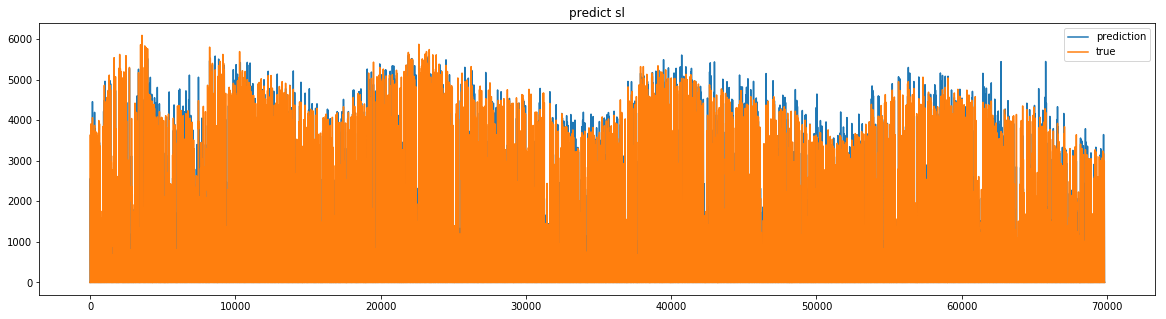

In [224]:
plt.figure(figsize=(20, 5))
plt.plot(processed_prediction, label = "prediction")
plt.plot(true, label = "true")
plt.legend()
plt.title("predict sl")

In [226]:
# epochsの暴力
print(calc_mae(processed_prediction, true))

198.43133961


In [227]:
validation = mlp_model.validation()[0]
validation = validation.reshape(validation.shape[0] * validation.shape[1])
processed_validation = denormalize_array(validation, kwh_min, kwh_max)

In [228]:
Y_val = mlp_model.Y_val
Y_val = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1])
Y_val = denormalize_array(Y_val, kwh_min, kwh_max)

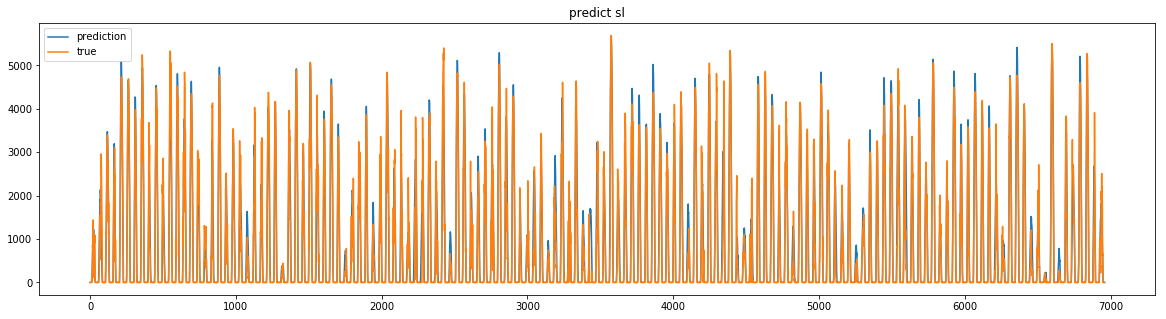

In [229]:
plt.figure(figsize=(20, 5))
plt.plot(processed_validation, label = "prediction")
plt.plot(Y_val, label = "true")
plt.legend()
plt.title("predict sl")

In [230]:
# これも別のモデルで学習したモデルなのでやはりダメっぽい
print(calc_mae(processed_validation, Y_val))

187.443315788


In [231]:
# X_predictによる予測
predictions = mlp_model.predict(X_predict)[0]
predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)

In [232]:
processed_prediction

array([ 1.02819085,  1.13619947,  1.31615806, ...,  1.4397229 ,
        0.82271838,  1.45067322], dtype=float32)

In [298]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
s_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
e_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
predict_data = pd.DataFrame({"datetime":amd_30['datetime'][s_idx:e_idx+1], "predict_SOLA0"+str(target_place):processed_prediction})
predict_data.index = np.arange(len(predict_data))

In [299]:
predict_data['datetime'] = predict_data['datetime'].map(lambda X : set_datetime(X))

In [300]:
predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t')

### **層を二つにすると？(slの予測に使ってました)**

In [57]:
class Two_Layer_MLP:
    def __init__(self, X, Y, epochs = 100, batch_size = 100, model_name = "test_model"):
        # 学習データと検証用データに分けておく
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.1)))
        self.X = X # 入力
        self.Y = Y # 教師
        self.X_val = X_val # 検証用
        self.Y_val = Y_val #検証用
        
        '''
        諸変数の設定
        '''
        self.input_layer_size = self.X.shape[1] #入力層の数
        self.hidden1_layer_size = 200 # 第1隠れ層の数、適当
        self.hidden2_layer_size = 100 # 第2隠れ層の数、適当
        self.output_layer_size = self.Y.shape[1] #出力層の数
        self.batch_size = batch_size #バッチサイズ
        self.learning_rate = 0.01 # 学習率 適当
        self.epochs = epochs #エポック数
        
        # 学習データの保存
        self.model_name = str(model_name)
        
        
    def shuffle(self):
        '''
        ミニバッチかする際にランダムにシャッフル
        '''
        idx = [i for i in range(self.X.shape[0])]
        np.random.shuffle(idx)
        xs = np.array([[y for y in list(self.X[r])] for r in idx])
        ys = np.array([self.Y[r] for r in idx])
        return xs, ys
        
    def inference(self, input_ph):
        '''
        グラフの構築
        '''
        
        # 重みとバイアスの初期化
        hidden1_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden1_layer_size], stddev=0.01), name='hidden1_w')
        hidden1_b = tf.Variable(tf.truncated_normal([self.hidden1_layer_size]), name='hidden1_b')
        hidden2_w = tf.Variable(tf.truncated_normal([self.hidden1_layer_size, self.hidden2_layer_size], stddev=0.01), name='hidden2_w')
        hidden2_b = tf.Variable(tf.truncated_normal([self.hidden2_layer_size]), name='hidden2_b')
        output_w = tf.Variable(tf.truncated_normal([self.hidden2_layer_size, self.output_layer_size], stddev=0.01), name='output_w')
        output_b = tf.Variable(tf.truncated_normal([self.output_layer_size]), name='output_b')
        
        # 計算
        hidden1 = tf.sigmoid(tf.matmul(input_ph, hidden1_w) + hidden1_b)
        hidden2 = tf.sigmoid(tf.matmul(hidden1, hidden2_w) + hidden2_b)
        output = tf.sigmoid(tf.matmul(hidden2, output_w) + output_b)
        
        weights = [hidden1_w, hidden2_w, output_w, hidden1_b, hidden2_b, output_b]
        
        return output, weights
        
    def loss(self, output_ph, actual_ph):
        '''
        MSEを使用
        '''
        cost = tf.reduce_mean(tf.abs((output_ph - actual_ph)))
        tf.summary.scalar('loss', cost)
        return cost
    
    def training(self, cost):
        '''
        adamを仕様beta1, beta2は元論文の推奨値を仕様
        '''
        with tf.name_scope("training") as scope:
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999).minimize(cost)
            return optimizer
    
    def train(self):
        '''
        学習
        '''
        random.seed(0)
        np.random.seed(0)
        tf.set_random_seed(0)
        n_batch = self.X.shape[0] // self.batch_size
        
        with tf.Graph().as_default():
            # 変数の用意
            input_ph = tf.placeholder('float', [None, self.input_layer_size], name='input')
            actual_ph = tf.placeholder('float', [None, self.output_layer_size], name='actual_value')

            prediction, weights = self.inference(input_ph)
            cost = self.loss(prediction, actual_ph)
            optimizer = self.training(cost)

            # TensorBoardで可視化する
            summary = tf.summary.merge_all()
            # 初期化
            init = tf.global_variables_initializer()
                
            # ここから学習
            with tf.Session() as sess:
                # 学習したモデルも保存しておく
                saver = tf.train.Saver()
                summary_writer = tf.summary.FileWriter("/tmp/tensorflow_log", graph=sess.graph)
                sess.run(init)

                for epoch in range(self.epochs):
                    X_, Y_ = self.shuffle()
                    for i in range(n_batch):
                        start = i * self.batch_size
                        end = start + self.batch_size
                        inputs  = X_[start:end]
                        actuals = Y_[start:end]
                        train_dict = {
                            input_ph:      inputs,
                            actual_ph:     actuals,
                        }
                    
                    sess.run(optimizer, feed_dict=train_dict)

                    if (epoch) % (self.epochs//10) == 0:
                        val_dict = {
                            input_ph:      self.X_val,
                            actual_ph:     self.Y_val,
                        }
                        summary_str, train_loss = sess.run([summary, cost], feed_dict=val_dict)
                        print("train#%d, validation loss: %e" % (epoch, train_loss))
                        summary_writer.add_summary(summary_str, epoch)
                        
                    datas = sess.run(weights)
                    saver.save(sess,  "./data/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")
                    
                datas = sess.run(weights)
                saver.save(sess, "./data/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")
                
    def predict(self, X_predict, model_name = "test_model"):
        '''
        予測期間に該当するデータから予測
        '''
        # 予測に使う変数の用意
        tf.reset_default_graph()
        input_ph = tf.placeholder("float", [None, self.input_layer_size], name='input')
        prediction, weights = self.inference(input_ph)
        pre_dict = {
            input_ph: X_predict,
        }
        
        # 初期化
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            # 保存したモデルをロード
            saver = tf.train.Saver()
            saver.restore(sess,  "./data/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")

            # ロードしたモデルを使って予測結果を計算
            expected_output = sess.run([prediction], feed_dict=pre_dict)


        return expected_output

In [58]:
mlp_model = Two_Layer_MLP(X, Y, epochs = 3000, model_name = "tow_layer_"+model_name)

In [59]:
mlp_model.train()

train#0, validation loss: 4.142499e-01
train#200, validation loss: 1.924573e-01
train#400, validation loss: 1.918128e-01
train#600, validation loss: 1.919960e-01
train#800, validation loss: 1.940695e-01
train#1000, validation loss: 1.926724e-01
train#1200, validation loss: 1.921177e-01
train#1400, validation loss: 1.927541e-01
train#1600, validation loss: 1.921887e-01
train#1800, validation loss: 1.927760e-01


In [60]:
predictions = mlp_model.predict(X_predict)[0]
predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
processed_prediction = denormalize_array(predictions, output_min, output_max)

INFO:tensorflow:Restoring parameters from ./data/tow_layer_nagoya_osaka_hamamatsu/tow_layer_nagoya_osaka_hamamatsu.ckpt


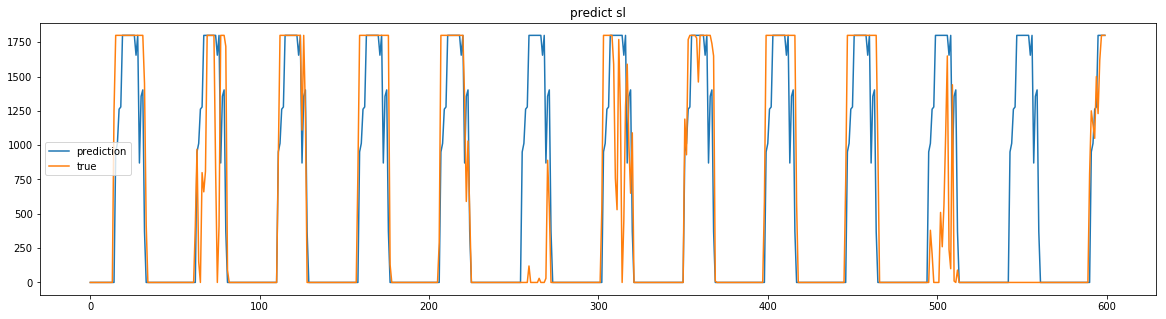

In [61]:
plt.figure(figsize=(20, 5))
plt.plot(processed_prediction[0:600], label = "prediction")
plt.plot(np.array(test_output_sl)[0:600], label = "true")
plt.legend()
plt.title("predict sl")

In [62]:
print(calc_mae(processed_prediction, np.array(test_output_sl)))

[ 355.76062874]
